In [58]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import pickle
import anndata as ad
%matplotlib inline
# now, make regression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.metrics
import scanpy as sc

In [2]:
# import base eGRN structure
class EnhancerGRN:
    """
    Core enhancer GRN dictionary structure.
    Lets make it as simple as possible, and reverse each dictionary order
    for maximal lookup speed (given the slowness of python of course).
    """
    def __init__(self):
        # pandas dataframe for the full data
        self.TF_motif_data     = None
        self.Full_peak_data    = None
        self.Full_TFBS_data    = None
        self.Full_TG_peak_data = None
        self.TF_set            = None
        self.test_variable     = None

        # TF - Motif layer and inverse
        self.tf_tfbs_map = {}  # connects all TFs to a TFBS (motif)
        self.tfbs_tf_map = {}  # connects a TFBS (motif) to all its TFs
        # TFBS - RE layer and inverse
        self.tfbs_re_map = {}  # map each tfbs to all its REs
        self.re_tfbs_map = {}  # map each RE to all its TFBS
        # TF - RE layer and inverse
        self.tf_re_map   = {}  # map each tfbs to all its REs
        self.re_tf_map   = {}  # map each RE to all its TFBS
        # TG - RE layer and inverse
        self.tg_re_map   = {}  # map each tfbs to all its REs
        self.re_tg_map   = {}  # map each RE to all its TFBS
        # TF - TG layer and inverse
        self.tf_tg_map   = {}  # map each tfbs to all its REs
        self.tg_tf_map   = {}  # map each RE to all its TFBS

    def load_TF_list(self, path):
        """
        Expected: A csv file that contains motifs classified as
        Alternative input: a list or set of TFs
        """
        if type(path) == str:
            self.TF_set = set(pd.read_csv(Lovering_TF_list, header=None)[0])
        if type(path) == set or type(path) == list:
            self.TF_set = set(path)
        
    def load_tf_motif_data(self, path):
        """
        Expected: A python dictionary that maps for each motif what TFs are binding.
        """
        with open(path, 'rb') as handle:
            self.TF_motif_data = pickle.load(handle)

    def load_peak_data(self, path):
        """
        Expected: A csv file, containing the peak, as well as footprint scores
        """
        self.Full_peak_data = pd.read_csv(path, index_col=0)
        
    def load_TG_peak_data(self, path):
        """
        Expected: A bed file, containing 
        """
        self.Full_TG_peak_data = pd.read_csv(path, sep='\t', header=None)

    def load_TFBS_peak_data(self, path):
        """
        Expected: A csv file, containing the peak, as well as 
        """
        self.Full_TFBS_data = pd.read_csv(path, sep='\t', header=None) 
        
    def create_tf_tfbs_map(self, TF_filter=True, capitalize_TFs = True, features = ['direct', 'indirect\nor predicted']):
        """
        Function to make a tf_tfbs mapping as well as its inverse. All non-mapping motifs are removed.
        If TF_filter is set to True, all motifs are additionally filtered to target only TFs 
        """

        for motif in self.TF_motif_data:
            
            # get current targets
            current_targets = self.TF_motif_data[motif]
            # strip motif
            motif = str(motif).rpartition('_')[0]
            new_target_list = []
            # add all TFs in all defined feature variables
            for feature in features:
                new_target_list.extend(current_targets[feature])
            # capitalize all elements and remove redundance
            if capitalize_TFs == True:
                new_target_list = set([x.upper() for x in  new_target_list])
            else:
                new_target_list = set(new_target_list)
            # intersect with the TF set
            new_target_list = self.TF_set.intersection(new_target_list)
            #print(new_target_list)
            # add features if set is not empty
            if len(new_target_list) > 0:
                self.tfbs_tf_map[str(motif)] = new_target_list
            # add inverse 
            for TF in new_target_list: 
                if TF not in self.tf_tfbs_map:
                    self.tf_tfbs_map[TF] = {str(motif)}
                else:
                    self.tf_tfbs_map[TF].add(str(motif))
                    
    def create_tfbs_re_map(self, motif_score_threshold = 3, motif_name_index = 3, peak_start_index = 6, motif_score_index = 4):
        """
        Create a mapping between motif positions and their respective REs. This is done 
        on the base of the already prepared Full_TFBS_data. This contains at the inital
        positions the information of the motif, and on the last positions the information 
        of the peaks. With motif_name_index and peak_start_index, one can indicate the corresponding
        columbs of the motif name (identifier) as well as the name of the RE (generallt tracked
        asexpressed as chr_start_end in this analysis).
        """
        # filter TFBS for motif score threshold
        filtered_peaks = self.Full_TFBS_data[self.Full_TFBS_data[motif_score_index] >=  motif_score_threshold]

        for index, row in filtered_peaks.iterrows():
            # get the name of the motif, as well as its peak position
            source = row[motif_name_index]
            target = str(row[peak_start_index])+'_'+str(row[peak_start_index+1])+'_'+str(row[peak_start_index+2])
            # add it to the tfbs_re_map
            if source not in self.tfbs_re_map:
                self.tfbs_re_map[str(source)] = {str(target)}
            else:
                self.tfbs_re_map[str(source)].add(str(target))
            # add the inverse to re_tfbs_map
            if target not in self.re_tfbs_map:
                self.re_tfbs_map[target] = {str(str(source))}
            else:
                self.re_tfbs_map[target].add(str(str(source)))
                
    def create_tf_re_map(self):
        """
        Map the TFs to the RE via its motifs. Function needs the previously functions 
        create_tf_tfbs_map() and create_tfbs_re_map() to be run.
        """
        # check status of self.tfbs_re_map and self.tfbs_tf_map:
        if len(self.tfbs_re_map) == 0 or len(self.tfbs_tf_map) == 0:
            print("Run create_tf_tfbs_map() and create_tfbs_re_map() first to enable the mapping function")
            return 'Error'

        for motif1 in self.tfbs_re_map:
            # Check whether the motif has annotated TFs that bind it
            if motif1 in self.tfbs_tf_map:

                # add for each TF the set of REs it binds too
                for TF in self.tfbs_tf_map[motif1]:
                    if TF not in self.tf_re_map:
                        self.tf_re_map[TF] = self.tfbs_re_map[motif1]
                    else:
                        self.tf_re_map[TF].union(self.tfbs_re_map[motif1])

                # add for each RE all TF that bind it
                for RE in self.tfbs_re_map[motif1]:
                    if RE not in self.re_tf_map:
                        self.re_tf_map[RE] = self.tfbs_tf_map[motif1]
                    else:
                        self.re_tf_map[RE].union(self.tfbs_tf_map[motif1])
                        
    def create_re_tg_map(self, TSS_threshold_up=500000, TSS_threshold_down=500000, chromosome_index=0, peak_start_index=1, peak_end_index = 2, tss_index = 6, gene_id_index=8):
        """
        Takes the TSS-peak annotations and transforms them into dictionaries.
        In case the file name has differetn headers, the index parameters can be changed to
        match column headers
        
        TODO: since there was an error in the first implementation, TSS_threshold_up will be used for both directions
        for now, instead of custom TSS
        """
        # check precondition for function
        if len(self.Full_TG_peak_data) == 0:
            print("Provide Full_TG_peak_data")
        
        # first, filter to desired max TSS distance. 
        Filtered_TG_peak_data = self.Full_TG_peak_data.copy()

        # since we need to check rather specific condtions, we do it in a zip loop and not in the df
        pass_filter = []
        for i,j,k in zip(Filtered_TG_peak_data[peak_start_index], Filtered_TG_peak_data[peak_end_index], Filtered_TG_peak_data[tss_index]):
            center_of_peak = j-(int(j-i)/2)
            # check position for upstream condition
            if center_of_peak <= k:
                if abs(k-center_of_peak) <= TSS_threshold_up:
                    pass_filter.append(True)
                else:
                    pass_filter.append(False)
            if center_of_peak > k:
                if abs(k-center_of_peak) <= TSS_threshold_down:
                    pass_filter.append(True)
                else:
                    pass_filter.append(False)
        Filtered_TG_peak_data['pass_filter'] = pass_filter
        Filtered_TG_peak_data = Filtered_TG_peak_data[Filtered_TG_peak_data['pass_filter'] == True]
        
#        Filtered_TG_peak_data = Filtered_TG_peak_data[ abs( abs(Filtered_TG_peak_data[peak_start_index]-Filtered_TG_peak_data[peak_end_index]) - Filtered_TG_peak_data[tss_index]) <= TSS_threshold_up   ]
        self.test_variable = Filtered_TG_peak_data.copy()
        # Last, create re_tg_map and tg_re_map based on the filter set-up
        
        for index, row in Filtered_TG_peak_data.iterrows():
            TG   = str(row[gene_id_index])
            peak = str(row[chromosome_index])+'_'+str(row[peak_start_index])+'_'+str(row[peak_end_index])
            # add TG_RE layer
            if TG not in self.tg_re_map:
                self.tg_re_map[TG] = set()
                self.tg_re_map[TG].add(peak)
            else:
                self.tg_re_map[TG].add(peak)
            # add RE_TG layer
            if peak not in self.re_tg_map:
                self.re_tg_map[peak] = set()
                self.re_tg_map[peak].add(TG)
            else:
                self.re_tg_map[peak].add(TG)
                
    def create_tf_tg_map(self):
        """
        Map all TF to their potential target genes and vice versa.
        Carefull: saturation effects occur if too many combinations are considered, leading
        to an effect that every TF connects to every TG
        """

        # Create TF-TG relation based on TF-RE and RE-TG relation
        for TF in self.tf_re_map.keys():
            for RE in self.tf_re_map[TF]:
                if RE in self.re_tg_map:
                    for TG in self.re_tg_map[RE]:
                        # fill tf_tg_map
                        if TF not in self.tf_tg_map:
                            self.tf_tg_map[TF] = set()
                            self.tf_tg_map[TF].add(TG)
                        else:
                            self.tf_tg_map[TF].add(TG)
                        # fill tg_tf_map
                        if TG not in self.tg_tf_map:
                            self.tg_tf_map[TG] = set()
                            self.tg_tf_map[TG].add(TF)
                        else:
                            self.tg_tf_map[TG].add(TF)    

In [3]:
# def regressTargets(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=20, verbose_eval=False):
#     """
#     An XBGoost wrapper function 
#     """
#     return xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=20, verbose_eval=False)


# def trainBackgroundModel(params, X_train, y_train, num_round, evals=watchlist, early_stopping_rounds=20, number_repetitions = 100, verbose_eval=False):
#     """
#     An XBGoost wrapper function 
#     """
#     importance_score_per_feature = {}
#     for rep in range(number_repetitions):
#         np.random.shuffle(y_train)    
#         dtrain = xgb.DMatrix(X_train, label=y_train)
#         model = regressTargets(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=20, verbose_eval=False)
#         importance_scores = model.get_score(importance_type="gain")
#         for f in importance_scores:
#             if f not in importance_score_per_feature:
#                 importance_score_per_feature[f] = [importance_scores[f]]
#             else:
#                 importance_score_per_feature[f].append(importance_scores[f])
#     return importance_score_per_feature



def getTargetAndPredictorExpression(adata, base_eGRN, targets, random_state=42, verbose=True):
    """
    Extract the corresponding features from an adata and returns a matrix.
    Right now, the target should only be one gene, and predictors can be multiple genes
    """
    # prepare target gene
    filtered_adata = adata[:, adata.var.index.isin(targets)]
    y = filtered_adata.X.toarray()

    if verbose == True:
        print('potential regulators:', len(base_eGRN.tg_tf_map[target[0]]))

    potential_regulators = base_eGRN.tg_tf_map[target[0]]
    # remove target if necessary
    if target[0] in potential_regulators:
        potential_regulators.remove(target[0])             

    filtered_adata = adata[:, adata.var.index.isin(potential_regulators)]
    X              = filtered_adata.X.toarray()

    if verbose == True:
        print('expressed regulators:', len(X[0]))
    feature_map = {f"f{i}": name for i, name in enumerate(list(filtered_adata.var.index))}
    return y, X, feature_map

In [59]:
# I add dependencies here once more 
from sklearn.model_selection import train_test_split
class ModelGRN:
    """
    This class should be able to run the modelling for each GRN. It should save all model relevenat information
    for further look-up, and be able to perform all necessary functionalities for the GRN model. Ideally, models
    will be named according to their respective targets.
    """
    def __init__(self, X, y, feature_map, params=None):
        # pandas dataframe for the full data
        self.params                = params    # Dictionalry to pass to XGboost
        self.X                     = X
        self.y                     = y
        self.feature_map           = feature_map
        self.X_train               = None
        self.X_test                = None
        self.y_train               = None
        self.y_test                = None
        self.y_pred                = None
        self.y_pred_train          = None
        self.model                 = None
        self.random_seed           = None
        self.num_training_rounds   = 300
        self.early_stopping_rounds = 20
        self.importance_scores     = None
        self.evals_result          = {}
        self.test_mae              = None
        self.train_mae             = None
        self.data_mean             = None

    def makeTrainTestSplit(self, test_size=0.2):
        """
        Make a train and test split with sklearn function
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        # Train model

    def trainModel(self, importance_type="gain"):
        """
        Make a train and test split with sklearn function
        """

        # DMatrix for XGBoost (optional, but efficient)
        dtrain = xgb.DMatrix(self.X_train, label=self.y_train)
        dtest  = xgb.DMatrix(self.X_test, label=self.y_test)
        print(dtrain)
        num_round = self.num_training_rounds
        watchlist = [(dtrain, "train"), (dtest, "eval")]
        #print(params)
        self.model = xgb.train(self.params, dtrain, num_round, evals=watchlist,  early_stopping_rounds=20, evals_result=self.evals_result, verbose_eval=False)
        
        # Predictions
        self.y_pred_test  = self.model.predict(dtest)
        self.y_pred_train = self.model.predict(dtrain)
        mse_train = mean_squared_error(self.y_train, self.y_pred_train)
        mse_test  = mean_squared_error(self.y_test, self.y_pred_test)
        mae_train = mean_absolute_error(self.y_train, self.y_pred_train)
        mae_test  = mean_absolute_error(self.y_test, self.y_pred_test)
        print(f"Mean Squared Error train: {mse_train}")
        print(f"Mean Squared Error test: {mse_test}")
        print(f"Mean: {np.mean(self.y)}")
        print(f"Rooe mean Squared Error: {mse_test**0.5}")

        # get importance scores
        self.importance_scores        = self.model.get_score(importance_type=importance_type)  # Default is 'weight'
        self.mapped_importance_scores = {self.feature_map.get(key, key): value for key, value in self.importance_scores.items() }
        self.test_mae                 = mae_test
        self.train_mae                = mae_train
        self.data_mean                = np.mean(self.y)
    
    def cleanup(self):
        """
        Since for now I want to have access to all models via pickle, it uses up way too much space on the disk.
        Lets see how much remains when we clean up everything but the model itself...
        """
        self.params                = params    # Dictionalry to pass to XGboost
        self.X                     = X
        self.y                     = y
        self.feature_map           = feature_map
        self.X_train               = None
        self.X_test                = None
        self.y_train               = None
        self.y_test                = None
        self.y_pred                = None
        self.y_pred_train          = None
        self.random_seed           = None
        self.num_training_rounds   = 300
        self.early_stopping_rounds = 20
        #self.importance_scores     = None
        self.evals_result          = {}    

In [91]:
# define model parameters
params = {
    "booster": "gbtree",          # Model type ('gbtree', 'gblinear', 'dart')
    "objective": "reg:squarederror",  # Regression loss
    "learning_rate": 0.1,         # Step size shrinkage (alias: eta)
    "max_depth": 5,               # Maximum depth of a tree
    "min_child_weight": 1,        # Minimum sum of instance weight (hessian) in a child
    "gamma": 0,                   # Minimum loss reduction required to make a split
    "subsample": 0.8,             # Subsample ratio of the training instances
    "colsample_bytree": 0.8,      # Subsample ratio of columns when constructing each tree
    "colsample_bylevel": 1,       # Subsample ratio of columns for each split
    "colsample_bynode": 1,        # Subsample ratio of columns for each tree node
    "lambda": 2,                  # L2 regularization term on weights
    "alpha": 0.8,                   # L1 regularization term on weights
    "tree_method": "auto",        # Tree construction algorithm
    "scale_pos_weight": 1,        # Balancing of positive and negative weights
    "eval_metric": "mae",        # Evaluation metric ('rmse', 'mae', etc.)
    "nthread": -1,                # Number of parallel threads (-1 = use all cores)
    "seed": 41,                    # Random seed
}

# train all models 
TG_models_exp_exp = {}

for target_gene in expression_adata.var_names[:2000]:#base_eGRN.TF_set: 
# select 
    if target_gene not in expression_adata.var_names:
        print(target_gene, 'not found')
        continue
    target = [target_gene]
    print(target)
    # get necessary data
    try:
        y, X, feature_map   = getTargetAndPredictorExpression(expression_adata, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue
    #y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=False)
    # # regression model
    if sum(y) < 500:
        print('skip',  target_gene, 'for number of counts')
    
    TG_models_exp_exp[target_gene] = ModelGRN(X,y,feature_map, params)
    # # prepare train-test split for model
    TG_models_exp_exp[target_gene].makeTrainTestSplit()
    # # train model
    TG_models_exp_exp[target_gene].trainModel()

['AL627309.1']
error with  AL627309.1
['AL627309.5']
error with  AL627309.5
['AL627309.4']
error with  AL627309.4
['AL669831.2']
error with  AL669831.2
['LINC01409']
potential regulators: 443
expressed regulators: 328
skip LINC01409 for number of counts
Mean Squared Error train: 0.043911684304475784
Mean Squared Error test: 0.06016601249575615
Mean: 0.04711246117949486
Rooe mean Squared Error: 0.24528761178615635
['FAM87B']
potential regulators: 456
expressed regulators: 335
skip FAM87B for number of counts
Mean Squared Error train: 0.0005877484800294042
Mean Squared Error test: 0.0015520296292379498
Mean: 0.0013026486849412322
Rooe mean Squared Error: 0.03939580725455375
['LINC01128']
potential regulators: 457
expressed regulators: 336
skip LINC01128 for number of counts
Mean Squared Error train: 0.028821401298046112
Mean Squared Error test: 0.05217864364385605
Mean: 0.04363873228430748
Rooe mean Squared Error: 0.2284264512788658
['LINC00115']
potential regulators: 456
expressed regul

KeyboardInterrupt: 

In [18]:
TG_models_exp_exp['PEX14']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

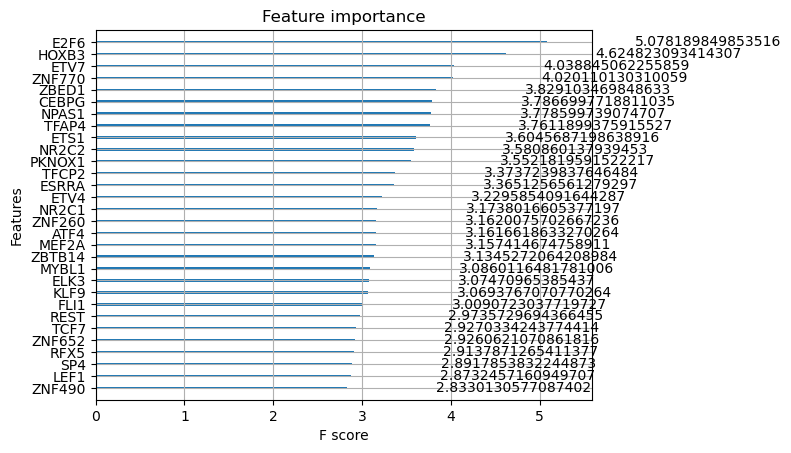

In [5]:
# import files
# import the base_eGRN pickle
with open('/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/baseGRN_500k.pickle', 'rb') as handle:
    base_eGRN = pickle.load(handle)

In [6]:
# import the expression data
result_folder      = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/'
data_folder        = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/data/human_PBMC_10x_10k/'
expression_adata   = ad.read_h5ad(data_folder+'pbmc_granulocyte_sorted_10k_gex_molecule_info_filtered_mg_mc_gc_mt_tc.h5ad')
geneactivity_adata = ad.read_h5ad(result_folder+'PBMC10k_gene_activity_matrix.h5ad')

In [15]:
# for now, limit to the top n HVG genes for testability reasons...
adata_tmp = expression_adata.copy()
sc.pp.normalize_total(adata_tmp, target_sum=1e4)  # Scale each cell to 10,000 total counts
sc.pp.log1p(adata_tmp)  # Log-transform the data
sc.pp.highly_variable_genes(adata_tmp, flavor="seurat_v3", n_top_genes=5000)
expression_adata.var['highly_variable'] = adata_tmp.var['highly_variable']


adata_tmp = geneactivity_adata.copy()
sc.pp.normalize_total(adata_tmp, target_sum=1e4)  # Scale each cell to 10,000 total counts
sc.pp.log1p(adata_tmp)  # Log-transform the data
sc.pp.highly_variable_genes(adata_tmp, flavor="seurat_v3", n_top_genes=5000)
geneactivity_adata.var['highly_variable'] = adata_tmp.var['highly_variable']

/apps/gent/RHEL9/zen3-ampere-ib/software/scanpy/1.9.8-foss-2023a/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/apps/gent/RHEL9/zen3-ampere-ib/software/scanpy/1.9.8-foss-2023a/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [19]:
geneactivity_adata_hvg = geneactivity_adata[:, geneactivity_adata.var['highly_variable']].copy()
expression_adata_hvg = expression_adata[:, expression_adata.var['highly_variable']].copy()

In [25]:
len(set(expression_adata_hvg.var_names).intersection(set(geneactivity_adata_hvg.var_names)))

876

In [26]:
print(adata_tmp)
#sc.pp.filter_cells(adata_tmp, min_genes=500)
sc.pp.filter_genes(adata_tmp, min_cells=500)
print(adata_tmp)

AnnData object with n_obs × n_vars = 9611 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
AnnData object with n_obs × n_vars = 9611 × 25660
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'log1p', 'hvg'


In [27]:
len(set(expression_adata.var_names).intersection(set(adata_tmp.var_names)))

16434

In [98]:
# define model parameters
params = {
    "booster": "gbtree",          # Model type ('gbtree', 'gblinear', 'dart')
    "objective": "reg:squarederror",  # Regression loss
    "learning_rate": 0.1,         # Step size shrinkage (alias: eta)
    "max_depth": 5,               # Maximum depth of a tree
    "min_child_weight": 1,        # Minimum sum of instance weight (hessian) in a child
    "gamma": 0,                   # Minimum loss reduction required to make a split
    "subsample": 0.8,             # Subsample ratio of the training instances
    "colsample_bytree": 0.8,      # Subsample ratio of columns when constructing each tree
    "colsample_bylevel": 1,       # Subsample ratio of columns for each split
    "colsample_bynode": 1,        # Subsample ratio of columns for each tree node
    "lambda": 2,                  # L2 regularization term on weights
    "alpha": 0.8,                   # L1 regularization term on weights
    "tree_method": "auto",        # Tree construction algorithm
    "scale_pos_weight": 1,        # Balancing of positive and negative weights
    "eval_metric": "mae",        # Evaluation metric ('rmse', 'mae', etc.)
    "nthread": -1,                # Number of parallel threads (-1 = use all cores)
    "seed": 41,                    # Random seed
}

# train all models 
TG_models_exp_exp = {}
TG_models_act_act = {}

for target_gene in expression_adata.var_names[:2000]:#base_eGRN.TF_set: 
# select 
    if target_gene not in expression_adata.var_names:
        print(target_gene, 'not found')
        continue
    target = [target_gene]
    print(target)
    # get necessary data
    try:
        y, X, feature_map   = getTargetAndPredictorExpression(expression_adata, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue
    #y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=False)
    # # regression model
    if sum(y) < 500:
        print('skip',  target_gene, 'for number of counts')
    
    TG_models_exp_exp[target_gene] = ModelGRN(X,y,feature_map, params)
    # # prepare train-test split for model
    TG_models_exp_exp[target_gene].makeTrainTestSplit()
    # # train model
    TG_models_exp_exp[target_gene].trainModel()

for target_gene in expression_adata.var_names[:2000]:#base_eGRN.TF_set: 
# select 
    if target_gene not in geneactivity_adata.var_names:
        print(target_gene, 'not found')
        continue
    target = [target_gene]
    print(target)
    # get necessary data
    try:
        y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue
    #y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=False)
    # # regression model
    if sum(y) < 500:
        print('skip',  target_gene, 'for number of counts')
    
    TG_models_act_act[target_gene] = ModelGRN(X,y,feature_map, params)
    # # prepare train-test split for model
    TG_models_act_act[target_gene].makeTrainTestSplit()
    # # train model
    TG_models_act_act[target_gene].trainModel()

['AL627309.1']
error with  AL627309.1
['AL627309.5']
error with  AL627309.5
['AL627309.4']
error with  AL627309.4
['AL669831.2']
error with  AL669831.2
['LINC01409']
potential regulators: 443
expressed regulators: 328
skip LINC01409 for number of counts
Mean Squared Error train: 0.043911684304475784
Mean Squared Error test: 0.06016601249575615
Mean: 0.04711246117949486
Rooe mean Squared Error: 0.24528761178615635
['FAM87B']
potential regulators: 456
expressed regulators: 335
skip FAM87B for number of counts
Mean Squared Error train: 0.0005877484800294042
Mean Squared Error test: 0.0015520296292379498
Mean: 0.0013026486849412322
Rooe mean Squared Error: 0.03939580725455375
['LINC01128']
potential regulators: 457
expressed regulators: 336
skip LINC01128 for number of counts
Mean Squared Error train: 0.028821401298046112
Mean Squared Error test: 0.05217864364385605
Mean: 0.04363873228430748
Rooe mean Squared Error: 0.2284264512788658
['LINC00115']
potential regulators: 456
expressed regul

In [99]:
len(TG_models_act_act)

1520

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

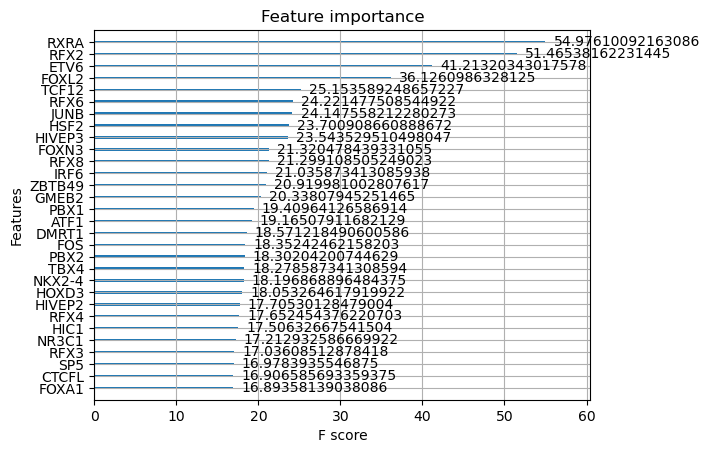

In [102]:
# Plot feature importance
# Plot feature importance
xgb.plot_importance(TG_models_act_act['RC3H1'].mapped_importance_scores, importance_type="gain", max_num_features=30)  # Show top 10 features
#plt.title("Feature Importance")
#plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

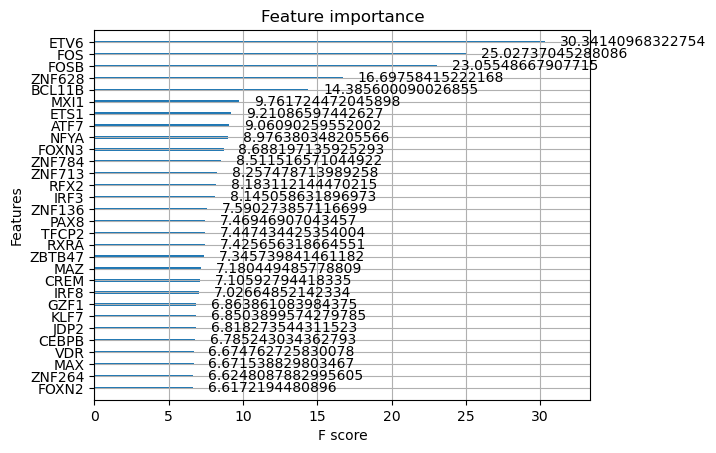

In [104]:
xgb.plot_importance(TG_models_exp_exp['RC3H1'].mapped_importance_scores, importance_type="gain", max_num_features=30)  # Show top 10 features

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

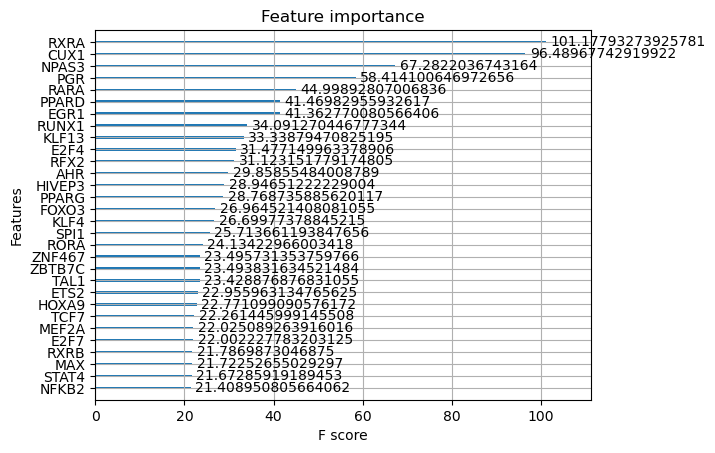

In [33]:
xgb.plot_importance(TG_models_act_act['ENO1'].mapped_importance_scores, importance_type="gain", max_num_features=30)  # Show top 10 features

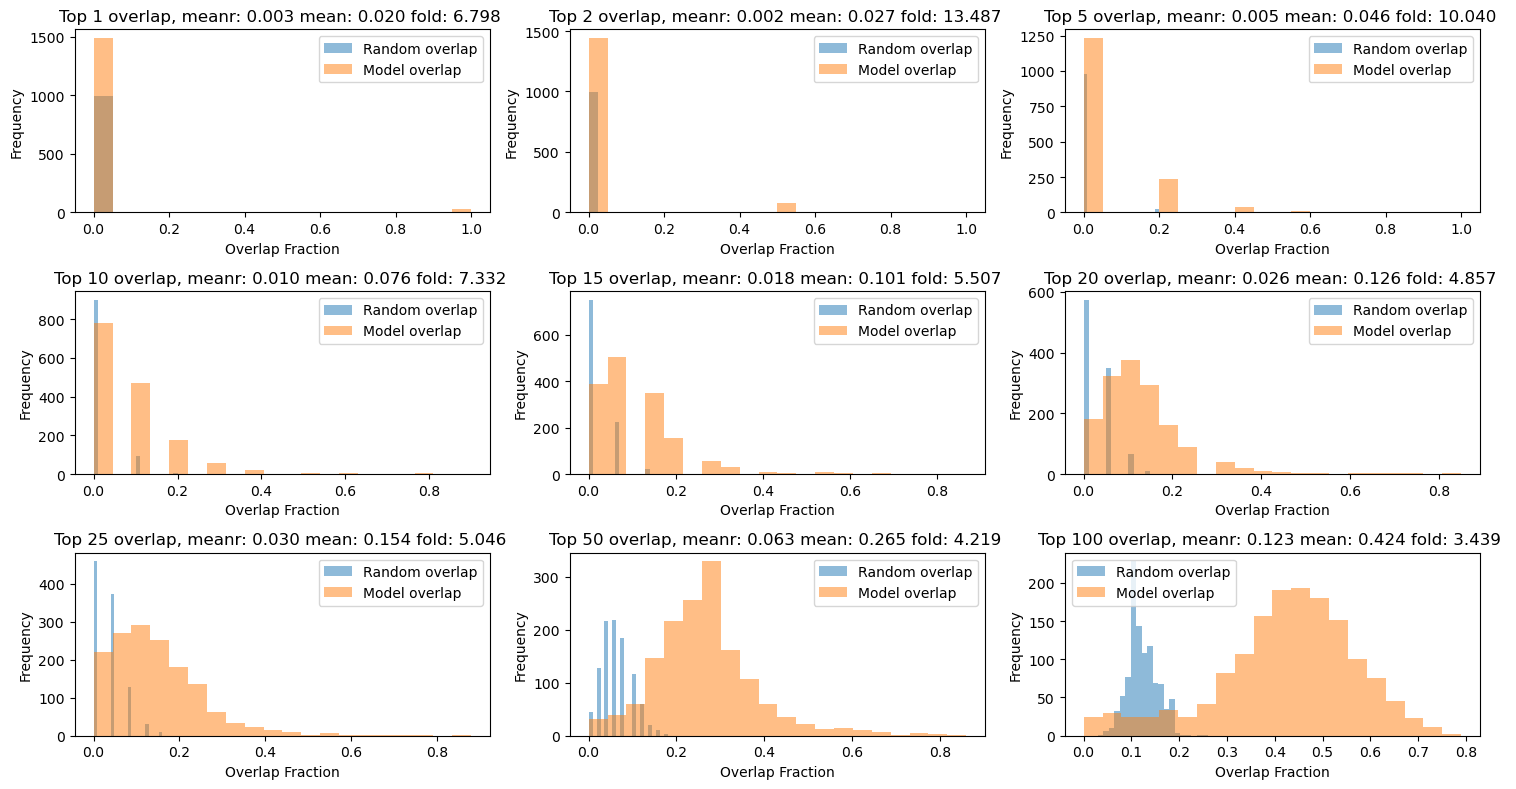

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# Define the number of rows and columns for the subplot grid
num_cols = 3  # Choose the number of columns for the subplot grid
num_rows = len([1, 2, 5, 10, 15, 20, 25, 50, 100]) // num_cols# + 1

# Create the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()  # Flatten the axes array to easily index

topk_list = [1, 2, 5, 10, 15, 20, 25, 50, 100]
for idx, topk in enumerate(topk_list):
    overlap_top_10_random = []
    overlap_top_10 = []
    overlapping_top_k = topk
    
    # Generate random overlap for background model
    for i in range(1000):
        TFs = set(base_eGRN.tf_re_map.keys())
        set_1 = set(random.sample(list(TFs), overlapping_top_k))
        set_2 = set(random.sample(list(TFs), overlapping_top_k))
        overlap_top_10_random.append(len(set_1.intersection(set_2)) / overlapping_top_k)
    
    # Calculate overlap for target gene models
    for tg in TG_models_act_act:
        top_10_features_act_act = sorted(TG_models_act_act[tg].mapped_importance_scores.items(), key=lambda x: x[1], reverse=True)[:overlapping_top_k]
        top_10_features_exp_exp = sorted(TG_models_exp_exp[tg].mapped_importance_scores.items(), key=lambda x: x[1], reverse=True)[:overlapping_top_k]
        top_10_feature_act_act_names = {feature for feature, score in top_10_features_act_act}
        top_10_feature_exp_exp_names = {feature for feature, score in top_10_features_exp_exp}
        overlap_top_10.append(len(top_10_feature_act_act_names.intersection(top_10_feature_exp_exp_names)) / overlapping_top_k)
    
    # Plot histograms on the corresponding axis
    axes[idx].hist(overlap_top_10_random, alpha=0.5, label='Random overlap', bins=20)
    axes[idx].hist(overlap_top_10, alpha=0.5, label='Model overlap', bins=20)
    axes[idx].set_title(f"Top {topk} overlap, meanr: {np.mean(overlap_top_10_random):.3f} mean: {np.mean(overlap_top_10):.3f} fold: {(np.mean(overlap_top_10)/np.mean(overlap_top_10_random)):.3f} ")
    axes[idx].set_xlabel('Overlap Fraction')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [216]:
# define model parameters
params = {
    "booster": "gbtree",          # Model type ('gbtree', 'gblinear', 'dart')
    "objective": "reg:squarederror",  # Regression loss
    "learning_rate": 0.1,         # Step size shrinkage (alias: eta)
    "max_depth": 5,               # Maximum depth of a tree
    "min_child_weight": 1,        # Minimum sum of instance weight (hessian) in a child
    "gamma": 0,                   # Minimum loss reduction required to make a split
    "subsample": 0.8,             # Subsample ratio of the training instances
    "colsample_bytree": 0.8,      # Subsample ratio of columns when constructing each tree
    "colsample_bylevel": 1,       # Subsample ratio of columns for each split
    "colsample_bynode": 1,        # Subsample ratio of columns for each tree node
    "lambda": 2,                  # L2 regularization term on weights
    "alpha": 0.8,                   # L1 regularization term on weights
    "tree_method": "auto",        # Tree construction algorithm
    "scale_pos_weight": 1,        # Balancing of positive and negative weights
    "eval_metric": "mae",        # Evaluation metric ('rmse', 'mae', etc.)
    "nthread": -1,                # Number of parallel threads (-1 = use all cores)
    "seed": 41,                    # Random seed
}

# traininf a mixture model... 
TG_models_exp_act = {}
TG_models_act_exp = {}

# filter for cells that are present in both assays
print('genes expression', len(set(expression_adata.obs_names)))
print('genes activity', len(set(geneactivity_adata.obs_names)))
print('intersection', len(set(geneactivity_adata.obs_names).intersection(set(expression_adata.obs_names))))
expression_adata_multiome = expression_adata[expression_adata.obs_names.isin(set(geneactivity_adata.obs_names).intersection(set(expression_adata.obs_names))), :]
geneactivity_adata_multiome =  geneactivity_adata[geneactivity_adata.obs_names.isin(set(geneactivity_adata.obs_names).intersection(set(expression_adata.obs_names))), :]


for target_gene in expression_adata_multiome.var_names[:400]:#base_eGRN.TF_set: 
# select 
    if target_gene not in set(expression_adata_multiome.var_names).intersection(set(geneactivity_adata_multiome.var_names)):
        print(target_gene, 'not found')
        continue
    target = [target_gene]
    print(target)
    # filter for cells that are present in both assays
    
    # get data for the predictors
    try:
        y_not_used, X, feature_map   = getTargetAndPredictorExpression(expression_adata_multiome, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue
    # get data for the target variable
    try:
        y, X_not_used, feature_map_not_used   = getTargetAndPredictorExpression(geneactivity_adata_multiome, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue

    if len(y) == 0:
        print('y-error')
        continue
    
    #y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=False)
    # # regression model
    if sum(y) < 500 or sum(sum(X)) < 500:
        print('skip',  target_gene, 'for number of counts')
        continue
    
    TG_models_exp_act[target_gene] = ModelGRN(X,y,feature_map, params)
    # # prepare train-test split for model
    TG_models_exp_act[target_gene].makeTrainTestSplit()
    # # train model
    TG_models_exp_act[target_gene].trainModel()


for target_gene in geneactivity_adata_multiome.var_names[:400]:#base_eGRN.TF_set: 
# select 
    if target_gene not in set(expression_adata_multiome.var_names).intersection(set(geneactivity_adata_multiome.var_names)):
        print(target_gene, 'not found')
        continue
    target = [target_gene]
    print(target)
    # filter for cells that are present in both assays
    
    # get data for the predictors
    try:
        y_not_used, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata_multiome, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue
    # get data for the target variable
    try:
        y, X_not_used, feature_map_not_used   = getTargetAndPredictorExpression(expression_adata_multiome, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue


    if y.shape[1] == 0:
        print('y-error')
        continue
        
    #y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=False)
    # # regression model
    if sum(y) < 500 or sum(sum(X)) < 500:
        print('skip',  target_gene, 'for number of counts')
        continue
    TG_models_act_exp[target_gene] = ModelGRN(X,y,feature_map, params)
    # # prepare train-test split for model
    TG_models_act_exp[target_gene].makeTrainTestSplit()
    # # train model
    TG_models_act_exp[target_gene].trainModel()



genes expression 9212
genes activity 9611
intersection 8076
AL627309.1 not found
AL627309.5 not found
AL627309.4 not found
AL669831.2 not found
['LINC01409']
potential regulators: 443
expressed regulators: 328
potential regulators: 443
expressed regulators: 443
Mean Squared Error train: 0.9587322397790425
Mean Squared Error test: 1.0775998073072588
Mean: 0.9874938088162457
Rooe mean Squared Error: 1.0380750489763535
['FAM87B']
potential regulators: 456
expressed regulators: 335
potential regulators: 456
expressed regulators: 456
Mean Squared Error train: 0.03998974365247641
Mean Squared Error test: 0.07193508044435694
Mean: 0.06723625557206538
Rooe mean Squared Error: 0.268207159569533
['LINC01128']
potential regulators: 457
expressed regulators: 336
potential regulators: 457
expressed regulators: 457
Mean Squared Error train: 0.5354223245387683
Mean Squared Error test: 0.6461273372254
Mean: 0.5716939078751857
Rooe mean Squared Error: 0.8038204633034668
['LINC00115']
potential regulato

In [211]:
len(TG_models_act_exp)

51

In [204]:
len(set(expression_adata_multiome.var_names).intersection(set(geneactivity_adata_multiome.var_names)))

18917

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

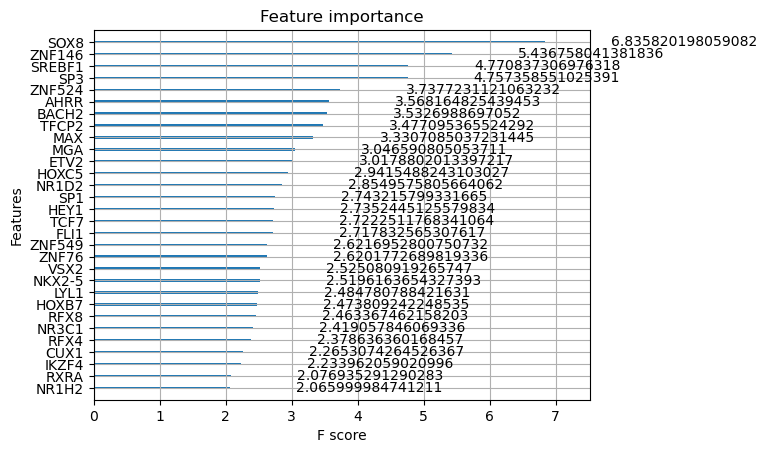

In [212]:

xgb.plot_importance(TG_models_act_exp['DFFA'].mapped_importance_scores, importance_type="gain", max_num_features=30)  # Show top 10 features

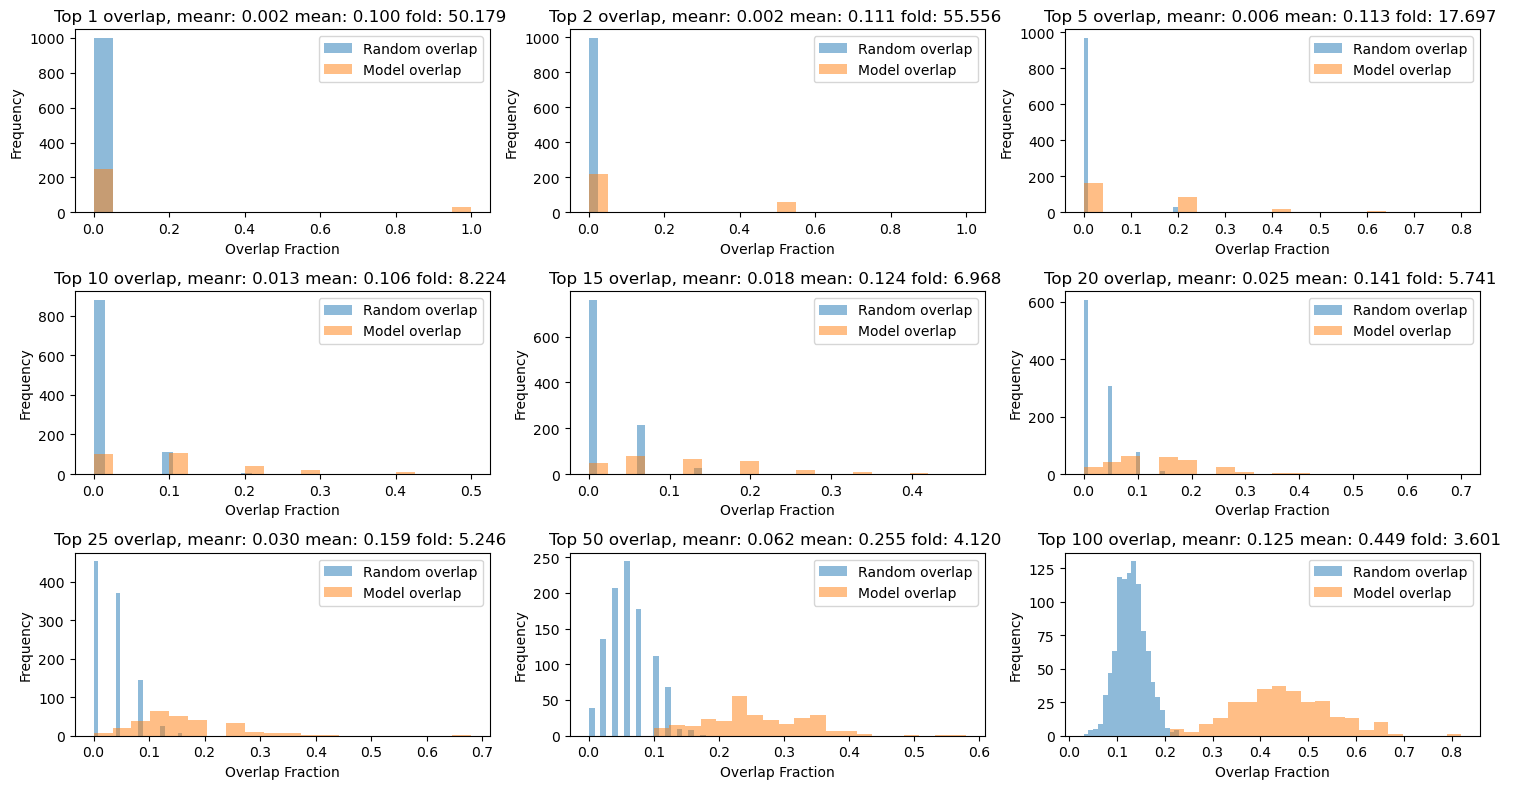

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# Define the number of rows and columns for the subplot grid
num_cols = 3  # Choose the number of columns for the subplot grid
num_rows = len([1, 2, 5, 10, 15, 20, 25, 50, 100]) // num_cols# + 1

# Create the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()  # Flatten the axes array to easily index

topk_list = [1, 2, 5, 10, 15, 20, 25, 50, 100]
for idx, topk in enumerate(topk_list):
    overlap_top_10_random = []
    overlap_top_10 = []
    overlapping_top_k = topk
    
    # Generate random overlap for background model
    for i in range(1000):
        TFs = set(base_eGRN.tf_re_map.keys())
        set_1 = set(random.sample(list(TFs), overlapping_top_k))
        set_2 = set(random.sample(list(TFs), overlapping_top_k))
        overlap_top_10_random.append(len(set_1.intersection(set_2)) / overlapping_top_k)
    
    # Calculate overlap for target gene models
    for tg in set(TG_models_exp_act).intersection(set(TG_models_act_act)):
        top_10_features_act_act = sorted(TG_models_exp_act[tg].mapped_importance_scores.items(), key=lambda x: x[1], reverse=True)[:overlapping_top_k]
        top_10_features_exp_exp = sorted(TG_models_act_act[tg].mapped_importance_scores.items(), key=lambda x: x[1], reverse=True)[:overlapping_top_k]
        top_10_feature_act_act_names = {feature for feature, score in top_10_features_act_act}
        top_10_feature_exp_exp_names = {feature for feature, score in top_10_features_exp_exp}
        overlap_top_10.append(len(top_10_feature_act_act_names.intersection(top_10_feature_exp_exp_names)) / overlapping_top_k)
    
    # Plot histograms on the corresponding axis
    axes[idx].hist(overlap_top_10_random, alpha=0.5, label='Random overlap', bins=20)
    axes[idx].hist(overlap_top_10, alpha=0.5, label='Model overlap', bins=20)
    axes[idx].set_title(f"Top {topk} overlap, meanr: {np.mean(overlap_top_10_random):.3f} mean: {np.mean(overlap_top_10):.3f} fold: {(np.mean(overlap_top_10)/np.mean(overlap_top_10_random)):.3f} ")
    axes[idx].set_xlabel('Overlap Fraction')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


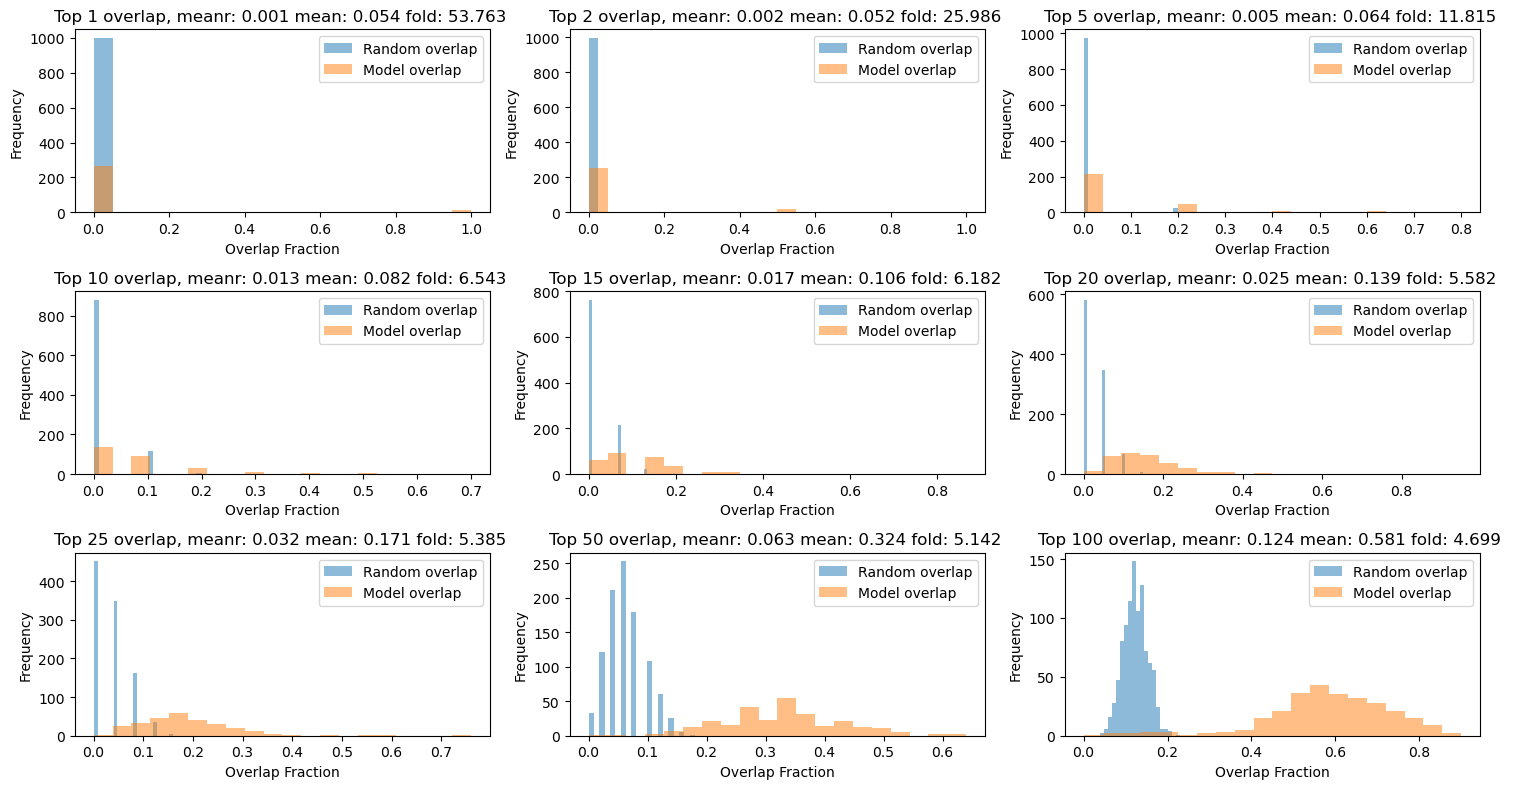

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# Define the number of rows and columns for the subplot grid
num_cols = 3  # Choose the number of columns for the subplot grid
num_rows = len([1, 2, 5, 10, 15, 20, 25, 50, 100]) // num_cols# + 1

# Create the subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()  # Flatten the axes array to easily index

topk_list = [1, 2, 5, 10, 15, 20, 25, 50, 100]
for idx, topk in enumerate(topk_list):
    overlap_top_10_random = []
    overlap_top_10 = []
    overlapping_top_k = topk
    
    # Generate random overlap for background model
    for i in range(1000):
        TFs = set(base_eGRN.tf_re_map.keys())
        set_1 = set(random.sample(list(TFs), overlapping_top_k))
        set_2 = set(random.sample(list(TFs), overlapping_top_k))
        overlap_top_10_random.append(len(set_1.intersection(set_2)) / overlapping_top_k)
    
    # Calculate overlap for target gene models
    for tg in set(TG_models_exp_act).intersection(set(TG_models_exp_exp)):
        top_10_features_act_act = sorted(TG_models_exp_act[tg].mapped_importance_scores.items(), key=lambda x: x[1], reverse=True)[:overlapping_top_k]
        top_10_features_exp_exp = sorted(TG_models_exp_exp[tg].mapped_importance_scores.items(), key=lambda x: x[1], reverse=True)[:overlapping_top_k]
        top_10_feature_act_act_names = {feature for feature, score in top_10_features_act_act}
        top_10_feature_exp_exp_names = {feature for feature, score in top_10_features_exp_exp}
        overlap_top_10.append(len(top_10_feature_act_act_names.intersection(top_10_feature_exp_exp_names)) / overlapping_top_k)
    
    # Plot histograms on the corresponding axis
    axes[idx].hist(overlap_top_10_random, alpha=0.5, label='Random overlap', bins=20)
    axes[idx].hist(overlap_top_10, alpha=0.5, label='Model overlap', bins=20)
    axes[idx].set_title(f"Top {topk} overlap, meanr: {np.mean(overlap_top_10_random):.3f} mean: {np.mean(overlap_top_10):.3f} fold: {(np.mean(overlap_top_10)/np.mean(overlap_top_10_random)):.3f} ")
    axes[idx].set_xlabel('Overlap Fraction')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [223]:
# how does it look overall with regard to base-line expression models?
for tg in TG_models_exp_exp:
    

{'LINC01409': <__main__.ModelGRN at 0x150782eac290>,
 'FAM87B': <__main__.ModelGRN at 0x1507828f4110>,
 'LINC01128': <__main__.ModelGRN at 0x150782f47710>,
 'LINC00115': <__main__.ModelGRN at 0x1507828f5350>,
 'FAM41C': <__main__.ModelGRN at 0x150782c85dd0>,
 'SAMD11': <__main__.ModelGRN at 0x150782ac3910>,
 'NOC2L': <__main__.ModelGRN at 0x150782ac3fd0>,
 'KLHL17': <__main__.ModelGRN at 0x150782ac1950>,
 'PLEKHN1': <__main__.ModelGRN at 0x150782bbc8d0>,
 'HES4': <__main__.ModelGRN at 0x150782b4c990>,
 'ISG15': <__main__.ModelGRN at 0x150782d1aa50>,
 'AGRN': <__main__.ModelGRN at 0x150782bd3190>,
 'C1orf159': <__main__.ModelGRN at 0x150782bd3690>,
 'LINC01342': <__main__.ModelGRN at 0x150782a94210>,
 'TTLL10': <__main__.ModelGRN at 0x150782dc4250>,
 'TNFRSF18': <__main__.ModelGRN at 0x1507829f7150>,
 'TNFRSF4': <__main__.ModelGRN at 0x150782dc4710>,
 'SDF4': <__main__.ModelGRN at 0x150782a8c110>,
 'B3GALT6': <__main__.ModelGRN at 0x14ffb73ec550>,
 'C1QTNF12': <__main__.ModelGRN at 0x14

In [142]:

filtered_adata = expression_adata[expression_adata.obs_names.isin(set(geneactivity_adata.obs_names).intersection(set(expression_adata.obs_names))), :]

In [137]:
len(set(geneactivity_adata.obs_names))

9611

In [138]:
len(set(geneactivity_adata.obs_names).intersection(set(expression_adata.obs_names)))

8076

In [130]:

for m in TG_models_exp_exp:
    top_10_features = sorted(TG_models_exp_exp[m].mapped_importance_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    print(top_10_features)

[('ATF7', 1.2963850498199463), ('FOXK2', 1.1975061893463135), ('SMAD2', 1.1885799169540405), ('CEBPD', 1.1872010231018066), ('TBX19', 1.185318946838379), ('IRF7', 1.0996342897415161), ('TFE3', 1.0429025888442993), ('CREM', 1.0396829843521118), ('PKNOX1', 1.0166581869125366), ('TFDP1', 0.9906635284423828)]
[('SMAD3', 0.2144331932067871), ('BACH1', 0.15762735903263092), ('CREBZF', 0.14645369350910187), ('MGA', 0.1307584047317505), ('ZBTB7A', 0.11910108476877213), ('ZNF24', 0.1060238629579544), ('MAFG', 0.10365967452526093), ('NFE2L2', 0.09312335401773453), ('RUNX1', 0.09258248656988144), ('FOXO1', 0.09091968089342117)]
[('ZNF121', 1.209968090057373), ('MEOX1', 0.8824511766433716), ('IRF2', 0.8052107691764832), ('RXRA', 0.7871911525726318), ('CREBZF', 0.5499013066291809), ('ZBTB7A', 0.522402822971344), ('CEBPD', 0.5125672817230225), ('BCL11B', 0.4917185604572296), ('YY1', 0.4766480326652527), ('FOS', 0.47526922821998596)]
[('FOXK1', 0.37295371294021606), ('RARA', 0.3695294260978699), ('NF

In [161]:
# now, lets play around with the regression for one TG

#target = ['TPT1']
target = ['SOX4']
filtered_adata = expression_adata[:, expression_adata.var.index.isin(target)]
# Print the summary of the filtered object
y = filtered_adata.X.toarray()

print('potential regulators:', len(base_eGRN.tg_tf_map[target[0]]))

potential_regulators = base_eGRN.tg_tf_map[target[0]]
# remove target if necessary
if target[0] in potential_regulators:
    potential_regulators.remove(target[0])   

filtered_adata = expression_adata[:, expression_adata.var.index.isin(potential_regulators)]
X               = filtered_adata.X.toarray()

print('expressed regulators:', len(X[0]))

potential regulators: 213
expressed regulators: 165


In [85]:
sum(geneactivity_adata[:,'SOX4'].X.toarray())

array([4024], dtype=uint32)

In [162]:
import random
y1 = random.shuffle(y)

In [163]:
sum(y > 0 )

array([483])

In [167]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DMatrix for XGBoost (optional, but efficient)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Default XGBoost parameters for regression
params = {
    "booster": "gbtree",          # Model type ('gbtree', 'gblinear', 'dart')
    "objective": "reg:squarederror",  # Regression loss
    "learning_rate": 0.1,         # Step size shrinkage (alias: eta)
    "max_depth": 10,               # Maximum depth of a tree
    "min_child_weight": 1,        # Minimum sum of instance weight (hessian) in a child
    "gamma": 0,                   # Minimum loss reduction required to make a split
    "subsample": 0.8,             # Subsample ratio of the training instances
    "colsample_bytree": 0.8,      # Subsample ratio of columns when constructing each tree
    "colsample_bylevel": 1,       # Subsample ratio of columns for each split
    "colsample_bynode": 1,        # Subsample ratio of columns for each tree node
    "lambda": 1,                  # L2 regularization term on weights
    "alpha": 0.8,                   # L1 regularization term on weights
    "tree_method": "auto",        # Tree construction algorithm
    "scale_pos_weight": 1,        # Balancing of positive and negative weights
    "eval_metric": "rmse",        # Evaluation metric ('rmse', 'mae', etc.)
    "nthread": -1,                # Number of parallel threads (-1 = use all cores)
    "seed": 41                    # Random seed
}

# Train model
num_round = 300
watchlist = [(dtrain, "train"), (dtest, "eval")]
model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

# Predictions
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Rooe mean Squared Error: {mse**0.5}")

[0]	train-rmse:0.47000	eval-rmse:0.59905
[1]	train-rmse:0.46547	eval-rmse:0.59914
[2]	train-rmse:0.45921	eval-rmse:0.59946
[3]	train-rmse:0.45593	eval-rmse:0.59953
[4]	train-rmse:0.44899	eval-rmse:0.59985
[5]	train-rmse:0.44373	eval-rmse:0.60016
[6]	train-rmse:0.43864	eval-rmse:0.60019
[7]	train-rmse:0.43394	eval-rmse:0.60057
[8]	train-rmse:0.42879	eval-rmse:0.60105
[9]	train-rmse:0.42370	eval-rmse:0.60151
[10]	train-rmse:0.42000	eval-rmse:0.60167
[11]	train-rmse:0.41544	eval-rmse:0.60198
[12]	train-rmse:0.40865	eval-rmse:0.60255
[13]	train-rmse:0.40654	eval-rmse:0.60279
[14]	train-rmse:0.39980	eval-rmse:0.60333
[15]	train-rmse:0.39306	eval-rmse:0.60423
[16]	train-rmse:0.38898	eval-rmse:0.60450
[17]	train-rmse:0.38428	eval-rmse:0.60522
[18]	train-rmse:0.37973	eval-rmse:0.60555
[19]	train-rmse:0.37491	eval-rmse:0.60580
[20]	train-rmse:0.37015	eval-rmse:0.60623
Mean Squared Error: 0.36751577258110046
Rooe mean Squared Error: 0.6062307915151626


In [8]:
# Get feature importance as a dictionary
importance_scores = model.get_score(importance_type="gain")  # Default is 'weight'

# Print feature importances
print("Feature Importances:")
for feature, score in importance_scores.items():
    print(f"{feature}: {score}")


Feature Importances:
f0: 0.581572413444519
f2: 1.7948607206344604
f5: 1.303134560585022
f7: 0.0029572248458862305
f8: 0.9356332421302795
f9: 1.9845798015594482
f10: 0.4740382134914398
f11: 0.2369566559791565
f12: 0.5308193564414978
f13: 0.08190005272626877
f15: 1.6755138635635376
f16: 0.4506385624408722
f17: 1.723314642906189
f18: 0.6098557114601135
f20: 2.244946002960205
f21: 0.10534105449914932
f22: 1.9948618412017822
f23: 0.2934284806251526
f24: 0.001647353172302246
f25: 1.1657612323760986
f26: 0.9398571252822876
f27: 1.3518695831298828
f28: 1.3440943956375122
f29: 1.5315247774124146
f30: 0.030481597408652306
f31: 0.9242559671401978
f33: 2.4315648078918457
f35: 1.487403392791748
f36: 1.6182353496551514
f37: 1.8046435117721558
f38: 1.0356762409210205
f39: 1.3941011428833008
f40: 2.244438648223877
f41: 0.9974257946014404
f42: 1.4458781480789185
f43: 1.520971417427063
f44: 1.5139107704162598
f45: 7.501188278198242
f47: 0.3877933621406555
f48: 3.6586573123931885
f50: 2.4868104457855225


In [9]:
sum(importance_scores.values())

151.7321621782612

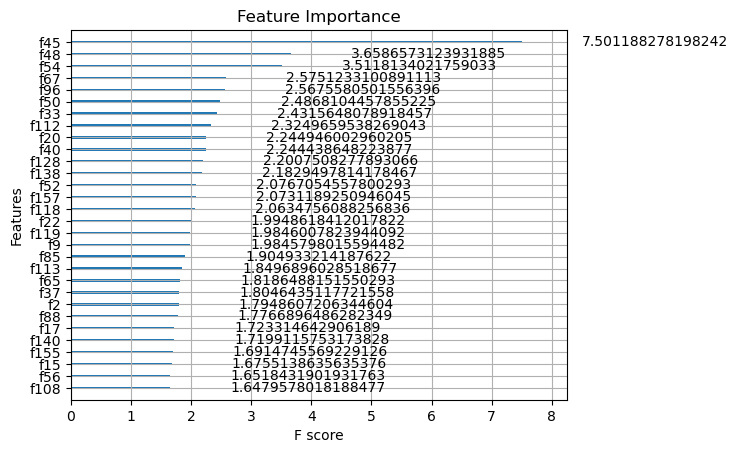

In [10]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(model, importance_type="gain", max_num_features=30)  # Show top 10 features
plt.title("Feature Importance")
plt.show()


In [12]:
import shap

ModuleNotFoundError: No module named 'shap'

In [11]:
# Create a mapping from feature indices to names
feature_map = {f"f{i}": name for i, name in enumerate(list(filtered_adata.var.index))}

# Get feature importance and map back to names
importance_scores = model.get_score(importance_type="gain")
importance_scores_named = {feature_map[k]: v for k, v in importance_scores.items()}
print(importance_scores_named)


{'PRDM16': 0.581572413444519, 'RUNX3': 1.7948607206344604, 'JUN': 1.303134560585022, 'CREB3L4': 0.0029572248458862305, 'MEF2D': 0.9356332421302795, 'ETV3': 1.9845798015594482, 'PBX1': 0.4740382134914398, 'NR5A2': 0.2369566559791565, 'ZNF281': 0.5308193564414978, 'ELF3': 0.08190005272626877, 'ATF3': 1.6755138635635376, 'BATF3': 0.4506385624408722, 'KLF11': 1.723314642906189, 'E2F6': 0.6098557114601135, 'FOSL2': 2.244946002960205, 'EPAS1': 0.10534105449914932, 'REL': 1.9948618412017822, 'MEIS1': 0.2934284806251526, 'TCF7L1': 0.001647353172302246, 'CREB1': 1.1657612323760986, 'SP140': 0.9398571252822876, 'SP100': 1.3518695831298828, 'NR2C2': 1.3440943956375122, 'RARB': 1.5315247774124146, 'EOMES': 0.030481597408652306, 'MITF': 0.9242559671401978, 'TFDP2': 2.4315648078918457, 'MECOM': 1.487403392791748, 'BCL6': 1.6182353496551514, 'TP63': 1.8046435117721558, 'RBPJ': 1.0356762409210205, 'NFKB1': 1.3941011428833008, 'LEF1': 2.244438648223877, 'SMAD1': 0.9974257946014404, 'IRF2': 1.4458781480

In [145]:
importance_scores['f0']

KeyError: 'f0'

In [16]:
y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=True)

potential regulators: 213
expressed regulators: 213


In [20]:
feature_map

{'f0': 'PRDM16',
 'f1': 'TP73',
 'f2': 'RUNX3',
 'f3': 'TAL1',
 'f4': 'FOXE3',
 'f5': 'FOXD2',
 'f6': 'JUN',
 'f7': 'FOXD3',
 'f8': 'TBX15',
 'f9': 'CREB3L4',
 'f10': 'MEF2D',
 'f11': 'ETV3',
 'f12': 'PBX1',
 'f13': 'NR5A2',
 'f14': 'ZNF281',
 'f15': 'ELF3',
 'f16': 'IRF6',
 'f17': 'ATF3',
 'f18': 'BATF3',
 'f19': 'SOX11',
 'f20': 'KLF11',
 'f21': 'E2F6',
 'f22': 'TCF23',
 'f23': 'FOSL2',
 'f24': 'EPAS1',
 'f25': 'REL',
 'f26': 'MEIS1',
 'f27': 'EGR4',
 'f28': 'TCF7L1',
 'f29': 'FOXI3',
 'f30': 'FOXD4L1',
 'f31': 'EN1',
 'f32': 'HOXD1',
 'f33': 'CREB1',
 'f34': 'SP140',
 'f35': 'SP100',
 'f36': 'GBX2',
 'f37': 'NR2C2',
 'f38': 'RARB',
 'f39': 'EOMES',
 'f40': 'MITF',
 'f41': 'GATA2',
 'f42': 'FOXL2',
 'f43': 'TFDP2',
 'f44': 'ZIC4',
 'f45': 'ZIC1',
 'f46': 'MECOM',
 'f47': 'BCL6',
 'f48': 'TP63',
 'f49': 'MSX1',
 'f50': 'RBPJ',
 'f51': 'NFKB1',
 'f52': 'LEF1',
 'f53': 'SMAD1',
 'f54': 'IRF2',
 'f55': 'MEF2C',
 'f56': 'IRF1',
 'f57': 'TCF7',
 'f58': 'FOXI1',
 'f59': 'NKX2-5',
 'f60': 'M

In [142]:
filtered_adata.var_names

Index(['PRDM16', 'TP73', 'RUNX3', 'TAL1', 'FOXD2', 'JUN', 'TBX15', 'CREB3L4',
       'MEF2D', 'ETV3',
       ...
       'BACH1', 'OLIG1', 'RUNX1', 'ERG', 'XBP1', 'SREBF2', 'ZNF41', 'TFE3',
       'ELF4', 'ZNF449'],
      dtype='object', length=165)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DMatrix for XGBoost (optional, but efficient)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Default XGBoost parameters for regression
params = {
    "booster": "gbtree",          # Model type ('gbtree', 'gblinear', 'dart')
    "objective": "reg:squarederror",  # Regression loss
    "learning_rate": 0.1,         # Step size shrinkage (alias: eta)
    "max_depth": 10,               # Maximum depth of a tree
    "min_child_weight": 1,        # Minimum sum of instance weight (hessian) in a child
    "gamma": 0,                   # Minimum loss reduction required to make a split
    "subsample": 0.8,             # Subsample ratio of the training instances
    "colsample_bytree": 0.8,      # Subsample ratio of columns when constructing each tree
    "colsample_bylevel": 1,       # Subsample ratio of columns for each split
    "colsample_bynode": 1,        # Subsample ratio of columns for each tree node
    "lambda": 1,                  # L2 regularization term on weights
    "alpha": 0.8,                   # L1 regularization term on weights
    "tree_method": "auto",        # Tree construction algorithm
    "scale_pos_weight": 1,        # Balancing of positive and negative weights
    "eval_metric": "rmse",        # Evaluation metric ('rmse', 'mae', etc.)
    "nthread": -1,                # Number of parallel threads (-1 = use all cores)
    "seed": 41                    # Random seed
}

# Train model
num_round = 300
watchlist = [(dtrain, "train"), (dtest, "eval")]
model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=20, verbose_eval=False)

# Predictions
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Rooe mean Squared Error: {mse**0.5}")

In [ ]:
# Define model parameters
params = {
    "booster": "gbtree",          # Model type ('gbtree', 'gblinear', 'dart')
    "objective": "reg:squarederror",  # Regression loss
    "learning_rate": 0.1,         # Step size shrinkage (alias: eta)
    "max_depth": 10,               # Maximum depth of a tree
    "min_child_weight": 1,        # Minimum sum of instance weight (hessian) in a child
    "gamma": 0,                   # Minimum loss reduction required to make a split
    "subsample": 0.8,             # Subsample ratio of the training instances
    "colsample_bytree": 0.8,      # Subsample ratio of columns when constructing each tree
    "colsample_bylevel": 1,       # Subsample ratio of columns for each split
    "colsample_bynode": 1,        # Subsample ratio of columns for each tree node
    "lambda": 1,                  # L2 regularization term on weights
    "alpha": 0.8,                   # L1 regularization term on weights
    "tree_method": "auto",        # Tree construction algorithm
    "scale_pos_weight": 1,        # Balancing of positive and negative weights
    "eval_metric": "rmse",        # Evaluation metric ('rmse', 'mae', etc.)
    "nthread": -1,                # Number of parallel threads (-1 = use all cores)
    "seed": 41                    # Random seed
}
# Train model
num_round = 300

In [149]:
## workflow
# Select target and extact information
target = ['TPT1']#['TPT1']#target = ['SOX4']
#y, X, feature_map   = getTargetAndPredictorExpression(expression_adata, base_eGRN, target, random_state=42, verbose=True)
y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=True)
# make a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create XGBoost matrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# define a watchlist ( allows to watch development of scores over different training rounds)
watchlist = [(dtrain, "train"), (dtest, "eval")]

# create the model
model = regressTargets(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=20, verbose_eval=False)

# print model stats
y_pred   = model.predict(dtest)
mse_test = mean_squared_error(y_test, y_pred)
#print(f"Mean Squared Error: {mse}")
print(f"Root mean Squared Error: {mse**0.5}")

# Calcualte importance scores per regulator
importance_scores = model.get_score(importance_type="gain")  # Default is 'weight'

# build a  background model on the same data with permutation and valdiate the importance scores based on that
background_IS = trainBackgroundModel(params, X_train, y_train, num_round, evals=watchlist, early_stopping_rounds=20, number_repetitions = 1000, verbose_eval=False)

potential regulators: 234
expressed regulators: 234
Root mean Squared Error: 0.5687912548738926


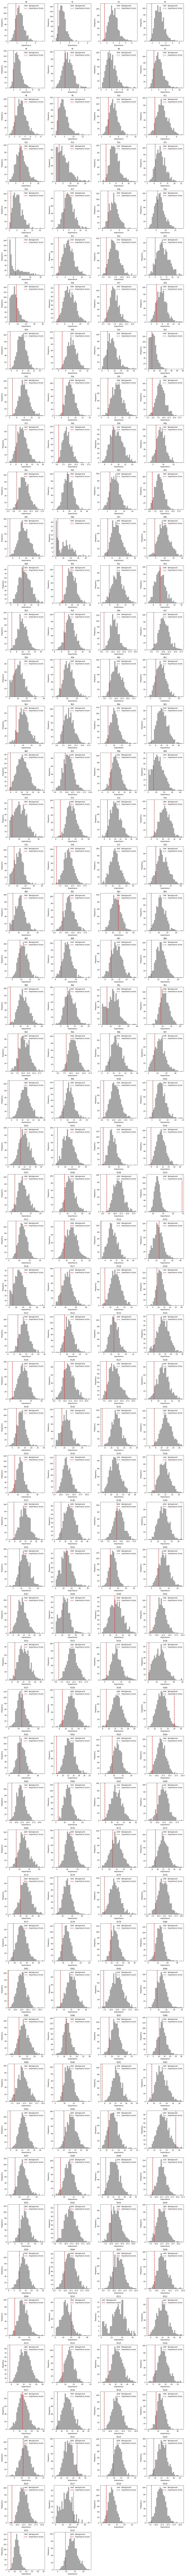

In [150]:
import matplotlib.pyplot as plt
import numpy as np

# Number of features
num_features = len(importance_scores)

# Create a figure with multiple subplots
cols = 4  # Number of columns
rows = (num_features + cols - 1) // cols  # Calculate rows needed
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each feature's distribution and importance score
for i, (feature, score) in enumerate(importance_scores.items()):
    ax = axes[i]
    background_dist = background_IS[feature]
    
    # Plot the histogram of the background distribution
    ax.hist(background_dist, bins=30, color='gray', alpha=0.7, label='Background')
    
    # Plot the importance score as a red line
    ax.axvline(score, color='red', linestyle='--', linewidth=2, label='Importance Score')
    
    # Set title and labels
    ax.set_title(feature)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Frequency')
    ax.legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


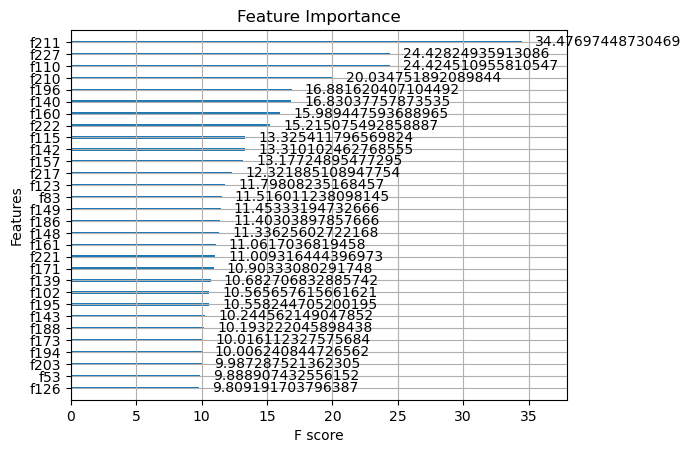

In [151]:
# Plot feature importance
xgb.plot_importance(model, importance_type="gain", max_num_features=30)  # Show top 10 features
plt.title("Feature Importance")
plt.show()

In [96]:
import numpy as np
from scipy.stats import percentileofscore

# Example distribution and value
#background_dist = np.random.normal(3, 1, 1000)  # Sample background distribution
x = 3.5  # Value to compute CDF for

# Using scipy.stats to get the percentile rank (CDF-like value)
cdf_value = percentileofscore(background_dist, x) / 100

print(f"The CDF value for x={x} in the given distribution is: {cdf_value:.4f}")


The CDF value for x=3.5 in the given distribution is: 0.6910


In [152]:
for f in importance_scores:
    br = background_IS[f]
    br.extend(((1000-len(br)) * [0]))
    p_value = 1 - percentileofscore(br, importance_scores[f]) / 100
    if p_value < 0.05:
        print(f, p_value)

f110 0.0
f140 0.0019999999999998908
f160 0.016999999999999904
f196 0.018000000000000016
f211 0.0
f222 0.04599999999999993
f227 0.030000000000000027


In [159]:
feature_map['f227']

'TBX22'

In [239]:
import pickle
import gzip
# Make a first complete modeling system, saving all models to file
# define model parameters
params = {
    "booster": "gbtree",          # Model type ('gbtree', 'gblinear', 'dart')
    "objective": "reg:squarederror",  # Regression loss
    "learning_rate": 0.1,         # Step size shrinkage (alias: eta)
    "max_depth": 5,               # Maximum depth of a tree
    "min_child_weight": 1,        # Minimum sum of instance weight (hessian) in a child
    "gamma": 0,                   # Minimum loss reduction required to make a split
    "subsample": 0.8,             # Subsample ratio of the training instances
    "colsample_bytree": 0.8,      # Subsample ratio of columns when constructing each tree
    "colsample_bylevel": 1,       # Subsample ratio of columns for each split
    "colsample_bynode": 1,        # Subsample ratio of columns for each tree node
    "lambda": 2,                  # L2 regularization term on weights
    "alpha": 0.8,                   # L1 regularization term on weights
    "tree_method": "auto",        # Tree construction algorithm
    "scale_pos_weight": 1,        # Balancing of positive and negative weights
    "eval_metric": "mae",        # Evaluation metric ('rmse', 'mae', etc.)
    "nthread": -1,                # Number of parallel threads (-1 = use all cores)
    "seed": 41,                    # Random seed
}

base_result_path = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/'
run_name         = 'run_1/'

# train all models 
TG_models_exp_exp = {}
TG_models_act_act = {}
TG_models_exp_act = {}
TG_models_act_exp = {}

##  core EXP_EXP model

for target_gene in expression_adata.var_names[:20]:#base_eGRN.TF_set: 
# select 
    if target_gene not in expression_adata.var_names:
        print(target_gene, 'not found')
        continue
    target = [target_gene]
    print(target)
    # get necessary data
    try:
        y, X, feature_map   = getTargetAndPredictorExpression(expression_adata, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue
    #y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=False)
    # # regression model
    if sum(y) < 500:
        print('skip',  target_gene, 'for number of counts')
    
    model = ModelGRN(X,y,feature_map, params)
    # # prepare train-test split for model
    model.makeTrainTestSplit()
    # # train model
    model.trainModel()

    # cleanup
    model.cleanup()

    # # save model
    # path_to_save = base_result_path+run_name+'/model_exp_exp/'+target_gene+'.pkl'
    # with open(path_to_save, "wb") as file:  # 'wb' means write in binary mode
    #     pickle.dump(model, file)
        
    path_to_save = base_result_path+run_name+'/model_exp_exp/'+target_gene+'.pkl'
    with gzip.open(path_to_save, "wb") as file:  # 'wb' means write in binary mode
        pickle.dump(model, file)    

##  core ACT_ACT model

for target_gene in expression_adata.var_names[:20]:#base_eGRN.TF_set: 
# select 
    if target_gene not in geneactivity_adata.var_names:
        print(target_gene, 'not found')
        continue
    target = [target_gene]
    print(target)
    # get necessary data
    try:
        y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue
    #y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=False)
    # # regression model
    if sum(y) < 500:
        print('skip',  target_gene, 'for number of counts')
    
    model = ModelGRN(X,y,feature_map, params)
    # # prepare train-test split for model
    model.makeTrainTestSplit()
    # # train model
    model.trainModel()
    model.cleanup()
    
    # save model
    # path_to_save = base_result_path+run_name+'/model_act_act/'+target_gene+'.pkl'
    # with open(path_to_save, "wb") as file:  # 'wb' means write in binary mode
    #     pickle.dump(model, file)

    path_to_save = base_result_path+run_name+'/model_act_act/'+target_gene+'.pkl'
    with gzip.open(path_to_save, "wb") as file:  # 'wb' means write in binary mode
        pickle.dump(model, file)

##  core EXP_ACT model

# filter for cells that are present in both assays
print('genes expression', len(set(expression_adata.obs_names)))
print('genes activity', len(set(geneactivity_adata.obs_names)))
print('intersection', len(set(geneactivity_adata.obs_names).intersection(set(expression_adata.obs_names))))
expression_adata_multiome = expression_adata[expression_adata.obs_names.isin(set(geneactivity_adata.obs_names).intersection(set(expression_adata.obs_names))), :]
geneactivity_adata_multiome =  geneactivity_adata[geneactivity_adata.obs_names.isin(set(geneactivity_adata.obs_names).intersection(set(expression_adata.obs_names))), :]


for target_gene in expression_adata_multiome.var_names[:20]:#base_eGRN.TF_set: 
# select 
    if target_gene not in set(expression_adata_multiome.var_names).intersection(set(geneactivity_adata_multiome.var_names)):
        print(target_gene, 'not found')
        continue
    target = [target_gene]
    print(target)
    # filter for cells that are present in both assays
    
    # get data for the predictors
    try:
        y_not_used, X, feature_map   = getTargetAndPredictorExpression(expression_adata_multiome, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue
    # get data for the target variable
    try:
        y, X_not_used, feature_map_not_used   = getTargetAndPredictorExpression(geneactivity_adata_multiome, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue

    if len(y) == 0:
        print('y-error')
        continue
    
    #y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=False)
    # # regression model
    if sum(y) < 500 or sum(sum(X)) < 500:
        print('skip',  target_gene, 'for number of counts')
        continue
    
    model = ModelGRN(X,y,feature_map, params)
    # # prepare train-test split for model
    model.makeTrainTestSplit()
    # # train model
    model.trainModel()
    model.cleanup()

    # save model
    # path_to_save = base_result_path+run_name+'/model_exp_act/'+target_gene+'.pkl'
    # with open(path_to_save, "wb") as file:  # 'wb' means write in binary mode
    #     pickle.dump(model, file)

    # save model
    path_to_save = base_result_path+run_name+'/model_exp_act/'+target_gene+'.pkl'
    with gzip.open(path_to_save, "wb") as file:  # 'wb' means write in binary mode
        pickle.dump(model, file)



# ##  core ACT_EXP model

for target_gene in geneactivity_adata_multiome.var_names[:40]:#base_eGRN.TF_set: 
# select 
    if target_gene not in set(expression_adata_multiome.var_names).intersection(set(geneactivity_adata_multiome.var_names)):
        print(target_gene, 'not found')
        continue
    target = [target_gene]
    print(target)
    # filter for cells that are present in both assays
    
    # get data for the predictors
    try:
        y_not_used, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata_multiome, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue
    # get data for the target variable
    try:
        y, X_not_used, feature_map_not_used   = getTargetAndPredictorExpression(expression_adata_multiome, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue


    if y.shape[1] == 0:
        print('y-error')
        continue
        
    #y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=False)
    # # regression model
    if sum(y) < 500 or sum(sum(X)) < 500:
        print('skip',  target_gene, 'for number of counts')
        continue
    model = ModelGRN(X,y,feature_map, params)
    # # prepare train-test split for model
    model.makeTrainTestSplit()
    # # train model
    model.trainModel()
    model.cleanup()

    # save model
    # path_to_save = base_result_path+run_name+'/model_act_exp/'+target_gene+'.pkl'
    # with open(path_to_save, "wb") as file:  # 'wb' means write in binary mode
    #     pickle.dump(model, file)

    path_to_save = base_result_path+run_name+'/model_act_exp/'+target_gene+'.pkl'
    with gzip.open(path_to_save, "wb") as file:  # 'wb' means write in binary mode
        pickle.dump(model, file)


['AL627309.1']
error with  AL627309.1
['AL627309.5']
error with  AL627309.5
['AL627309.4']
error with  AL627309.4
['AL669831.2']
error with  AL669831.2
['LINC01409']
potential regulators: 443
expressed regulators: 328
skip LINC01409 for number of counts
Mean Squared Error train: 0.043911684304475784
Mean Squared Error test: 0.06016601249575615
Mean: 0.04711246117949486
Rooe mean Squared Error: 0.24528761178615635
['FAM87B']
potential regulators: 456
expressed regulators: 335
skip FAM87B for number of counts
Mean Squared Error train: 0.0005877484800294042
Mean Squared Error test: 0.0015520296292379498
Mean: 0.0013026486849412322
Rooe mean Squared Error: 0.03939580725455375
['LINC01128']
potential regulators: 457
expressed regulators: 336
skip LINC01128 for number of counts
Mean Squared Error train: 0.028821401298046112
Mean Squared Error test: 0.05217864364385605
Mean: 0.04363873228430748
Rooe mean Squared Error: 0.2284264512788658
['LINC00115']
potential regulators: 456
expressed regul

KeyboardInterrupt: 

In [225]:
target_gene

'AGRN'

In [236]:
len(geneactivity_adata.var_names)

60606

In [ ]:
import scanpy as sc
import numpy as np

# Assuming `adata` is your AnnData object
mean_values = np.mean(geneactivity_adata.X)  # Mean expression per feature
#var_values = np.var(geneactivity_adata.X, axis=1)    # Variance per feature

# Add to `adata.var` for easy access
geneactivity_adata.var['mean_expression'] = mean_values
#geneactivity_adata.var['variance_expression'] = var_values.A1 if sc.sparse.issparse(geneactivity_adata.X) else var_values


In [ ]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)

In [248]:
geneactivity_adata

AnnData object with n_obs × n_vars = 9611 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

# Make GRN with minimal information saved
I want a test GRN for all models without using up too much disk/ram space, that can serve as a first proxy for how well the pipeline works. Moreover, we for now will use the same set of training parameters across all models. This has to be optimized later.

In [40]:
params = {
    "booster": "gbtree",          # Model type ('gbtree', 'gblinear', 'dart')
    "objective": "reg:squarederror",  # Regression loss
    "learning_rate": 0.1,         # Step size shrinkage (alias: eta)
    "max_depth": 5,               # Maximum depth of a tree
    "min_child_weight": 1,        # Minimum sum of instance weight (hessian) in a child
    "gamma": 0,                   # Minimum loss reduction required to make a split
    "subsample": 0.8,             # Subsample ratio of the training instances
    "colsample_bytree": 0.8,      # Subsample ratio of columns when constructing each tree
    "colsample_bylevel": 1,       # Subsample ratio of columns for each split
    "colsample_bynode": 1,        # Subsample ratio of columns for each tree node
    "lambda": 2,                  # L2 regularization term on weights
    "alpha": 0.8,                   # L1 regularization term on weights
    "tree_method": "auto",        # Tree construction algorithm
    "device": "cuda",   
    "scale_pos_weight": 1,        # Balancing of positive and negative weights
    "eval_metric": "mae",        # Evaluation metric ('rmse', 'mae', etc.)   => I use this as I do not want to have uninterpretable resutls when dooing root over [0.1] intervall compared to > 1 
    "nthread": -1,                # Number of parallel threads (-1 = use all cores)
    "seed": 41,                    # Random seed
}

In [31]:
# Data will be preped here to intersect genes from both platforms. This allows us to do a bit of dimensionality reductinon.
# The first idea of only using HVG was not very successful (800 genes overlapped of 5000). I therefore want to avoid this for now.
overlapping_genes  = set(expression_adata.var_names).intersection(set(geneactivity_adata.var_names))
expression_adata_i = expression_adata[:, list(overlapping_genes)].copy()
geneactivity_adata_i = geneactivity_adata[:, list(overlapping_genes)].copy()

In [72]:
base_result_path = '/scratch/gent/vo/000/gvo00027/projects/CBIGR/24JLR_GRN/results/human_PBMC_10x_10k/GRN_test_runs/'
run_name         = 'run_1/'

# train all models 
TG_models_exp_exp_scores            = {}
TG_models_exp_exp_evals             = {}
TG_models_exp_exp_pred_performance  = {}

TG_models_act_act_scores            = {}
TG_models_act_act_evals             = {}
TG_models_act_act_pred_performance  = {}

TG_models_exp_act_scores            = {}
TG_models_exp_act_evals             = {}
TG_models_exp_act_pred_performance  = {}

TG_models_act_exp_scores            = {}
TG_models_act_exp_evals             = {}
TG_models_act_exp_pred_performance  = {}

In [ ]:
##  core EXP_EXP model

for target_gene in expression_adata_i.var_names:#base_eGRN.TF_set: 
# select 
    if target_gene not in expression_adata_i.var_names:
        print(target_gene, 'not found')
        continue
    target = [target_gene]
    print(target)
    # get necessary data
    try:
        y, X, feature_map   = getTargetAndPredictorExpression(expression_adata_i, base_eGRN, target, random_state=40, verbose=True)
    except:
        print('error with ',target_gene)
        continue
    #y, X, feature_map   = getTargetAndPredictorExpression(geneactivity_adata, base_eGRN, target, random_state=42, verbose=False)
    # # regression model
    if sum(y) < 500:
        print('skip',  target_gene, 'for number of counts')
    
    model = ModelGRN(X,y,feature_map, params)
    # # prepare train-test split for model
    model.makeTrainTestSplit()
    # # train model
    model.trainModel()
    TG_models_exp_exp_scores[target_gene]           = model.mapped_importance_scores
    TG_models_exp_exp_evals[target_gene]            = model.evals_result
    TG_models_exp_exp_pred_performance[target_gene] = (model.data_mean, model.train_mae, model.test_mae)
    
    # cleanup
#    model.cleanup()

    # # save model
    # path_to_save = base_result_path+run_name+'/model_exp_exp/'+target_gene+'.pkl'
    # with open(path_to_save, "wb") as file:  # 'wb' means write in binary mode
    #     pickle.dump(model, file)
        
    # path_to_save = base_result_path+run_name+'/model_exp_exp/'+target_gene+'.pkl'
    # with gzip.open(path_to_save, "wb") as file:  # 'wb' means write in binary mode
    #     pickle.dump(model, file)    


['NEK8']
potential regulators: 338
expressed regulators: 253
skip NEK8 for number of counts
Mean Squared Error train: 0.021200451999902725
Mean Squared Error test: 0.03846970200538635
Mean: 0.029309596866369247
Rooe mean Squared Error: 0.19613694706858867
['PLAC4']
potential regulators: 204
expressed regulators: 167
skip PLAC4 for number of counts
Mean Squared Error train: 0.000241632413235493
Mean Squared Error test: 0.001100967638194561
Mean: 0.0006513243424706161
Rooe mean Squared Error: 0.0331808323915263
['TRBV20-1']
potential regulators: 306
expressed regulators: 254
skip TRBV20-1 for number of counts
Mean Squared Error train: 0.00116583367343992
Mean Squared Error test: 0.0021949508227407932
Mean: 0.0017368649132549763
Rooe mean Squared Error: 0.046850302269470935
['LINC02465']
potential regulators: 18
expressed regulators: 17
skip LINC02465 for number of counts
Mean Squared Error train: 0.0006395744276233017
Mean Squared Error test: 0.001635166583582759
Mean: 0.0008684324566274

<Axes: ylabel='Count'>

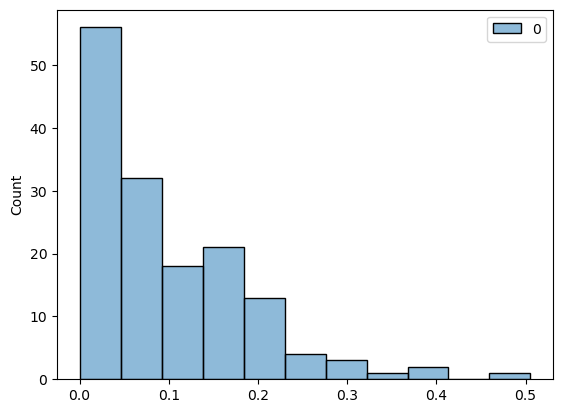

In [48]:
sns.histplot(model.mapped_importance_scores.values())

In [74]:
len(TG_models_exp_exp_scores)

17805

In [75]:
overall_length = 0
for TG in TG_models_exp_exp_scores:
    overall_length +=  len(TG_models_exp_exp_scores[TG])
print(overall_length)

1999356


In [85]:
overall_length = 0
train_improvements = []
test_improvements  = []
for TG in TG_models_exp_exp_evals:
    print(TG_models_exp_exp_evals[TG]['train']['mae'][0] - TG_models_exp_exp_evals[TG]['train']['mae'][-1])
    print(TG_models_exp_exp_evals[TG]['eval']['mae'][0] - TG_models_exp_exp_evals[TG]['eval']['mae'][-1])
    break
#print(overall_length)

0.01128281039991013
0.001047720241210845
